In [1]:
%run 0_Regressions_Common.ipynb

In [2]:
%run 0_NN_Common.ipynb

In [3]:
feature_sets = newcases_feature_sets
label = newcases_label
text_label = "new cases"
text_label_cap = "New Cases"
label_daily = "new_cases_Adj100k"

In [4]:
file_suffix='mar9'

with open('../OtherData/CombinedDFAdjPopulationExcessMobility_%s.pkl' % (file_suffix), 'rb') as handle:
    df = pickle.load(handle)
    
file_suffix='mar9'

In [5]:
with open('../OtherData/0_val_7_regions_mar9.pkl', 'rb') as handle:
    val_regions = pickle.load(handle)
     
regions = val_regions #list(set([x for x in val_regions if x not in regions_to_skip]))  
print("Number of val regions: %d" % (len(regions)))

Number of val regions: 7


In [6]:
features = feature_sets[17]

In [7]:
epochs = 1000
patience = 5

early_stop = keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=patience)

In [8]:
region_to_mse = dict()
region_to_ypred = dict()
    
for region in regions:
    
    od_df= df.where(df["Region"] == region).dropna()
    train = od_df.where(od_df["Date"] >= '2020-04-01').where(od_df["Date"] <= '2020-09-09').dropna()
    val = od_df.where(od_df["Date"] >= '2020-09-16').where(od_df["Date"] <= '2020-10-24').dropna()
    test = od_df.where(od_df["Date"] >= '2020-11-01').where(od_df["Date"] <= '2020-11-30').dropna()

    train_new = train.sort_index().dropna()
    val_new = val.sort_index().dropna()
    test_new = test.sort_index().dropna()
    features_min_max = preprocessing.MinMaxScaler()
    X_train = train_new[features]#features_min_max.fit_transform(train_new[features])
    X_val = val_new[features]#features_min_max.transform(val_new[features])
    X_test = test_new[features]# features_min_max.transform(test_new[features])
    X_train_t = reshape_for_rnn(X_train)
    X_val_t = reshape_for_rnn(X_val)
    X_test_t = reshape_for_rnn(X_test)
    y_train = train_new[label]
    y_val = val_new[label]
    y_test = test_new[label]
    mod = build_rnn_model(X_train, 8)


    history = mod.fit(X_train_t, y_train.values, epochs=epochs,
                      batch_size=1, shuffle=False, 
                      validation_data=[X_val_t, y_val.values],
                      verbose=0, callbacks=[PrintDot(), early_stop])
    y_pred = mod.predict(X_test_t, batch_size=1)
    #mod.save_weights("../ModelDump/test.h5")
    
    nov_mse = mean_squared_error(y_pred, y_test)
    
    region_to_mse[region] = nov_mse
    region_to_ypred[region] = y_pred


...........................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...............................................
......................................................................................
......
....................................................................................................
....................................................................................................
..............................................
...........................................

In [9]:
np.sqrt(np.mean(list(region_to_mse.values())))

5.956750674901637

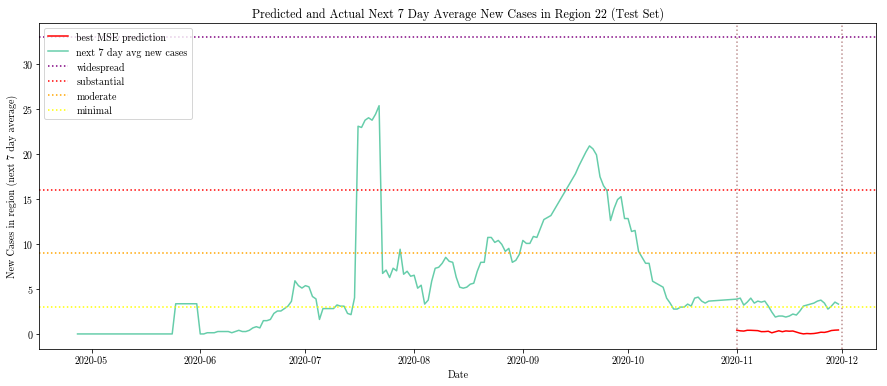

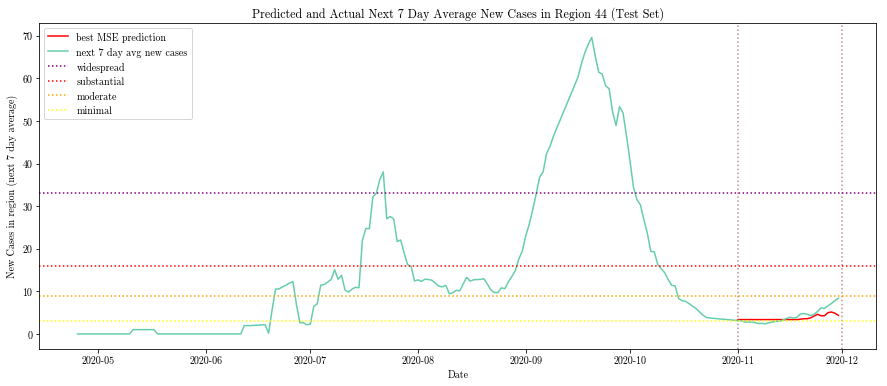

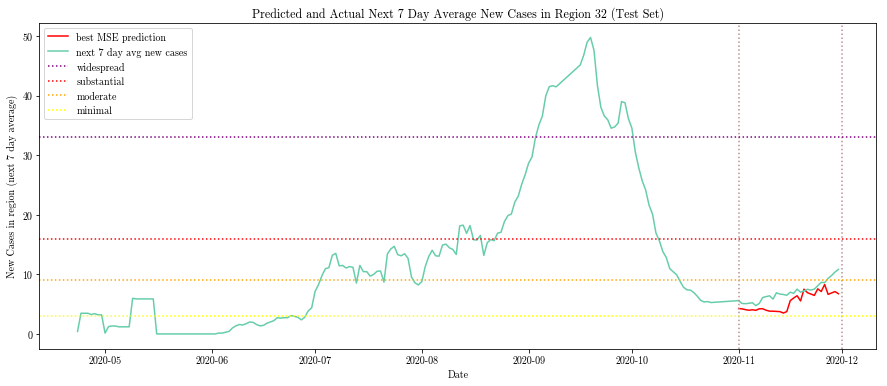

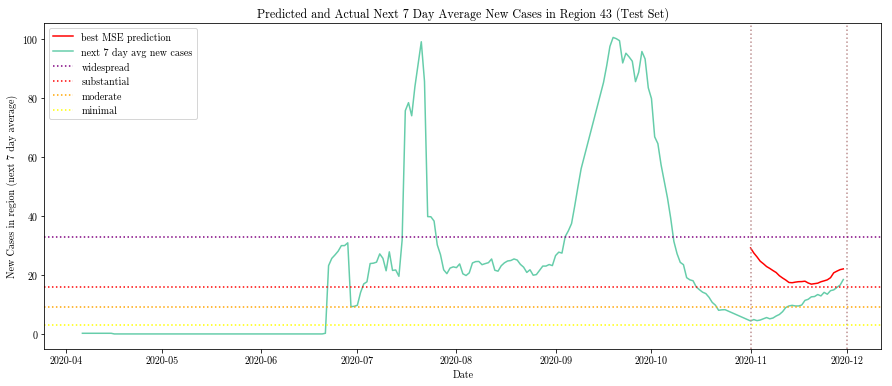

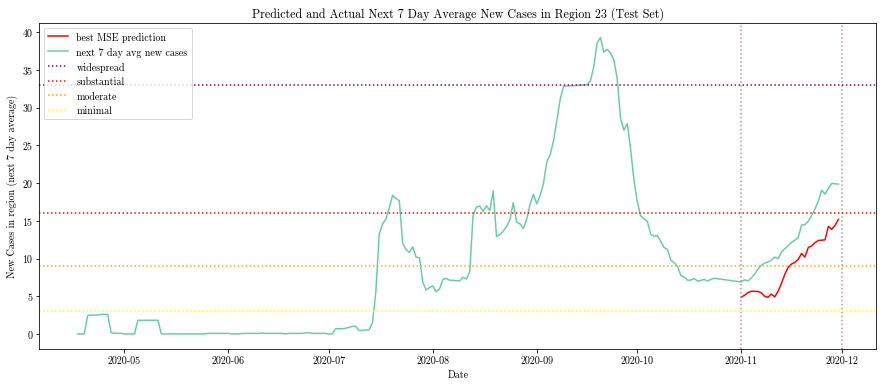

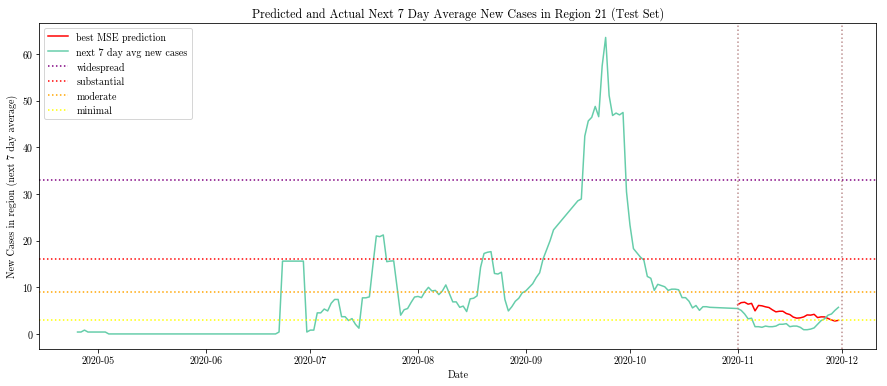

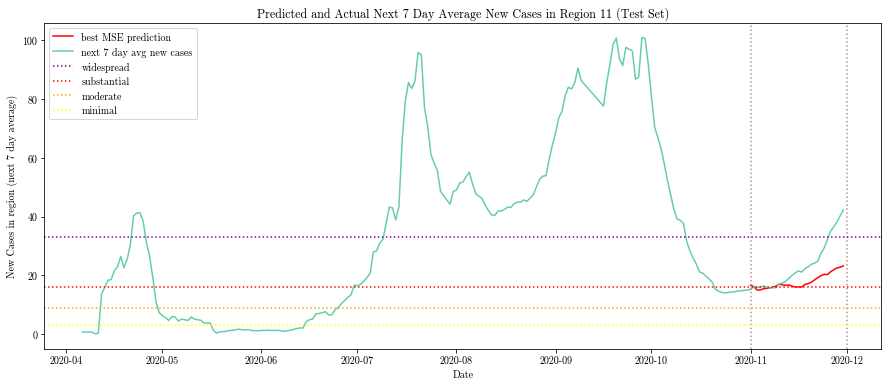

In [13]:
for region in regions:

    od_df= df.where(df["Region"] == region).dropna()
    train = od_df.where(od_df["Date"] >= '2020-04-01').where(od_df["Date"] <= '2020-09-09').dropna()
    val = od_df.where(od_df["Date"] >= '2020-09-16').where(od_df["Date"] <= '2020-10-24').dropna()
    test = od_df.where(od_df["Date"] >= '2020-11-01').where(od_df["Date"] <= '2020-11-30').dropna()

    train_new = train.sort_index().dropna()
    val_new = val.sort_index().dropna()
    test_new = test.sort_index().dropna()
    y_train = train_new[label]#features_min_max.fit_transform(train_new[features])
    y_val = val_new[label]#features_min_max.transform(val_new[features])
    y_test = test_new[label]# features_min_max.transform(test_new[features])
    train_copy = train_new.copy()
    val_copy = val_new.copy()
    test_copy = test_new.copy()

    train_copy["actual"] = y_train
    val_copy["actual"] = y_val
    test_copy["actual"] = y_test
    test_copy["best_mse"] = region_to_ypred[region]

    pred_all = pd.concat([train_copy, val_copy, test_copy])

    # plot the final result on a sample dataset    
    toplot = pred_all
    toplot['Date'] = pd.to_datetime(toplot['Date'])
    fig, ax = plt.subplots(figsize=(15,6))
    plt.plot(toplot['Date'], toplot['best_mse'], color='red', label='best MSE prediction')
    #plt.plot(toplot['Date'], toplot['best_ma'], color='blue', label='best MA prediction')
    plt.plot(toplot['Date'], toplot['actual'], color='mediumaquamarine', label='next 7 day avg %s' % (text_label))
    #plt.plot(toplot['Date'], toplot[label_daily], color='lightsteelblue', label='daily %s' % (text_label))
    plt.axvline(x='2020-12-01', color='rosybrown', linestyle='dotted')
    plt.axvline(x='2020-11-01', color='rosybrown', linestyle='dotted')
    plt.axhline(y=t5_nct, color='purple', linestyle='dotted', label='widespread')
    plt.axhline(y=t4_nct, color='red', linestyle='dotted', label='substantial')
    plt.axhline(y=t3_nct, color='orange', linestyle='dotted', label='moderate')
    plt.axhline(y=t2_nct, color='yellow', linestyle='dotted', label='minimal')
    plt.legend(loc=0)
    plt.xlabel("Date")
    plt.ylabel("%s in region (next 7 day average)" % (text_label_cap))
    plt.title("Predicted and Actual Next 7 Day Average %s in Region %d (Test Set)" % (text_label_cap, region))
    plt.show()